# The 1cycle policy

In [1]:
from fastai.gen_doc.nbdoc import *
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

## What is 1cycle?

This Callback allows us to easily train a network using Leslie Smith's 1cycle policy. To learn more about the 1cycle technique for training neural networks check out [Leslie Smith's paper](https://arxiv.org/pdf/1803.09820.pdf) and for a more graphical and intuitive explanation check out [Sylvain Gugger's post](https://sgugger.github.io/the-1cycle-policy.html).

To use our 1cycle policy we will need an [optimum learning rate](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html). We can find this learning rate by using a learning rate finder which can be called by using [`lr_finder`](/callbacks.lr_finder.html#callbacks.lr_finder). It will do a mock training by going over a large range of learning rates, then plot them against the losses. We will pick a value a bit before the minimum, where the loss still improves. Our graph would look something like this:

![onecycle_finder](imgs/onecycle_finder.png)

Here anything between `3x10^-2` and `10^-2` is a good idea.

Next we will apply the 1cycle policy with the chosen learning rate as the maximum learning rate. The original 1cycle policy has three steps:

    1. We progressively increase our learning rate from lr_max/div_factor to lr_max and at the same time we progressively decrease our momentum from mom_max to mom_min.
    2. We do the exact opposite: we progressively decrease our learning rate from lr_max to lr_max/div_factor and at the same time we progressively increase our momentum from mom_min to mom_max.
    3. We further decrease our learning rate from lr_max/div_factor to lr_max/(div_factor x 100) and we keep momentum steady at mom_max.
    
This gives the following form:

<img src="imgs/onecycle_params.png" alt="1cycle parameteres" width="500">

Unpublished work has shown even better results by using only two phases: the same phase 1, followed by a second phase where we do a cosine annealing from lr_max to 0. The momentum goes from mom_min to mom_max by following the symmetric cosine (see graph a bit below).

## Basic Training

The one cycle policy allows to train very quickly, a phenomenon termed [_superconvergence_](https://arxiv.org/abs/1708.07120). To see this in practice, we will first train a CNN and see how our results compare when we use the [`OneCycleScheduler`](/callbacks.one_cycle.html#OneCycleScheduler) with [`fit_one_cycle`](/train.html#fit_one_cycle).

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
model = simple_cnn((3,16,16,2))
learn = Learner(data, model, metrics=[accuracy])

First lets find the optimum learning rate for our comparison by doing an LR range test.

In [3]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


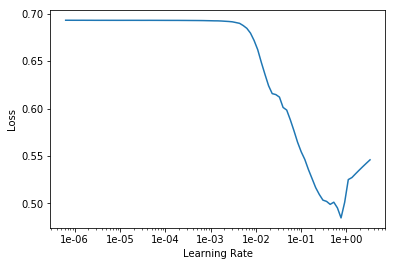

In [4]:
learn.recorder.plot()

Here 5e-2 looks like a good value, a tenth of the minimum of the curve. That's going to be the highest learning rate in 1cycle so let's try a constant training at that value.

In [5]:
learn.fit(2, 5e-2)

Total time: 01:31
epoch  train_loss  valid_loss  accuracy
1      0.081578    0.076827    0.974975  (00:45)
2      0.054172    0.060358    0.979392  (00:46)



We can also see what happens when we train at a lower learning rate

In [6]:
model = simple_cnn((3,16,16,2))
learn = Learner(data, model, metrics=[accuracy])
learn.fit(2, 5e-3)

Total time: 01:30
epoch  train_loss  valid_loss  accuracy
1      0.121981    0.107272    0.957311  (00:44)
2      0.073639    0.062796    0.979392  (00:45)



## Training with the 1cycle policy

Now to do the same thing with 1cycle, we use [`fit_one_cycle`](/train.html#fit_one_cycle).

In [7]:
model = simple_cnn((3,16,16,2))
learn = Learner(data, model, metrics=[accuracy])
learn.fit_one_cycle(2, 5e-2)

Total time: 01:30
epoch  train_loss  valid_loss  accuracy
1      0.094006    0.087283    0.971050  (00:45)
2      0.034530    0.027952    0.990186  (00:44)



This gets the best of both world and we can see how we get a far better accuracy and a far lower loss in the same number of epochs. It's possible to get to the same amazing results with training at constant learning rates, that we progressively diminish, but it will take a far longer time.

Here is the schedule of the lrs (left) and momentum (right) that the new 1cycle policy uses.

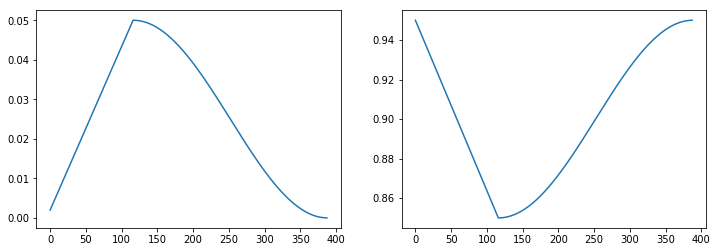

In [8]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
show_doc(OneCycleScheduler, doc_string=False)

<h2 id="OneCycleScheduler"><code>class</code> <code>OneCycleScheduler</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callbacks/one_cycle.py#L9" class="source_link">[source]</a></h2>

> <code>OneCycleScheduler</code>(`learn`:[`Learner`](/basic_train.html#Learner), `lr_max`:`float`, `moms`:`Floats`=`(0.95, 0.85)`, `div_factor`:`float`=`25.0`, `pct_start`:`float`=`0.3`) :: [`Callback`](/callback.html#Callback)

Create a [`Callback`](/callback.html#Callback) that handles the hyperparameters settings following the 1cycle policy for `learn`. `lr_max` should be picked with the [`lr_find`](/train.html#lr_find) test. In phase 1, the learning rates goes from `lr_max/div_factor` to `lr_max` linearly while the momentum goes from `moms[0]` to `moms[1]` linearly. In phase 2, the learning rates follows a cosine annealing from `lr_max` to 0, as the momentum goes from `moms[1]` to `moms[0]` with the same annealing.

In [ ]:
show_doc(OneCycleScheduler.steps, doc_string=False)

<h4 id="OneCycleScheduler.steps"><code>steps</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callbacks/one_cycle.py#L21" class="source_link">[source]</a></h4>

> <code>steps</code>(`steps_cfg`:`StartOptEnd`)

Build the [`Stepper`](/callback.html#Stepper) for the [`Callback`](/callback.html#Callback) according to `steps_cfg`.

In [ ]:
show_doc(OneCycleScheduler.on_train_begin, doc_string=False)

<h4 id="OneCycleScheduler.on_train_begin"><code>on_train_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callbacks/one_cycle.py#L26" class="source_link">[source]</a></h4>

> <code>on_train_begin</code>(`n_epochs`:`int`, `kwargs`:`Any`)

Initiate the parameters of a training for `n_epochs`.

In [ ]:
show_doc(OneCycleScheduler.on_batch_end, doc_string=False)

<h4 id="OneCycleScheduler.on_batch_end"><code>on_batch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callbacks/one_cycle.py#L39" class="source_link">[source]</a></h4>

> <code>on_batch_end</code>(`train`, `kwargs`:`Any`)

Prepares the hyperparameters for the next batch.